In [10]:
"""
Regularization
Deep Learning models have so much flexibility and capacity that overfitting can be a serious problem, if the training dataset is not big enough. Sure it does well on the training set, but the learned network doesn't generalize to new examples that it has never seen!

We will learn to: Use regularization in our deep learning models.

Let's first import the packages we are going to use.
"""

# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

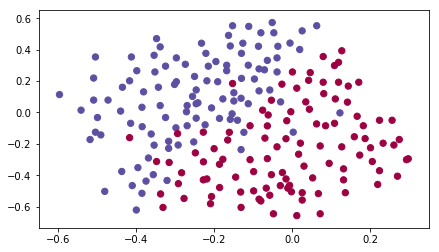

In [11]:
"""
Problem Statement: We have just been hired as an AI expert by the French Football Corporation. They would like us to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head.
They give us the following 2D dataset from France's past 10 games.

They give us the following 2D dataset from France's past 10 games.
"""
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [5]:
"""
2 - L2 Regularization
The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying our cost function
"""

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = lambd * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2*m)
    ### END CODER HERE ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [6]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.78648594516


In [7]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### START CODE HERE ### (approx. 1 line)
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    ### END CODE HERE ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### START CODE HERE ### (approx. 1 line)
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    ### END CODE HERE ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### START CODE HERE ### (approx. 1 line)
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd * W1) / m
    ### END CODE HERE ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [8]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


In [12]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


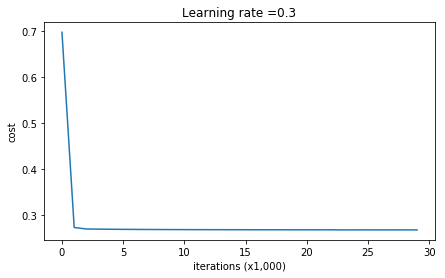

On the train set:
Accuracy: 0.938388625592
On the test set:
Accuracy: 0.93


In [13]:
"""
Let's now run the model with L2 regularization  (λ=0.7)(λ=0.7) . The model() function will call:

compute_cost_with_regularization instead of compute_cost
backward_propagation_with_regularization instead of backward_propagation
"""

parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


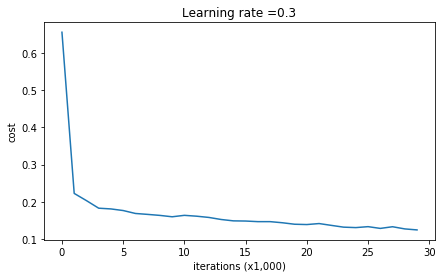

On the training set:
Accuracy: 0.947867298578
On the test set:
Accuracy: 0.915


In [14]:
"""
The test set accuracy increased to 93%. We have saved the French football team!
We are not overfitting the training data anymore. Let's plot the decision boundary.
"""

parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [17]:
"""
Observations:

The value of  λλ  is a hyperparameter that we can tune using a dev set.
L2 regularization makes our decision boundary smoother. If  λλ  is too large, it is also possible to "oversmooth", resulting in a model with high bias.
What is L2-regularization actually doing?:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function we drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.

What we should remember -- the implications of L2-regularization on:

The cost computation:
A regularization term is added to the cost
The backpropagation function:
There are extra terms in the gradients with respect to weight matrices
Weights end up smaller ("weight decay"):
Weights are pushed to smaller values.
"""

'\nObservations:\n\nThe value of  λλ  is a hyperparameter that we can tune using a dev set.\nL2 regularization makes our decision boundary smoother. If  λλ  is too large, it is also possible to "oversmooth", resulting in a model with high bias.\nWhat is L2-regularization actually doing?:\n\nL2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function we drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.\n\nWhat we should remember -- the implications of L2-regularization on:\n\nThe cost computation:\nA regularization term is added to the cost\nThe backpropagation function:\nThere are extra terms in the gradients with respect to weight matrices\nWeights end up smaller ("weight decay"):\nWeights are pushed to smaller val

In [18]:
"""
3 - Dropout
Finally, dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration. Watch these two videos to see what this means!
At each iteration, we shut down (= set to zero) each neuron of a layer with probability  1−keep_prob1−keep_prob  or keep it with probability  keep_probkeep_prob  (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration.
"""

"""
When we shut some neurons down, we actually modify our model. The idea behind drop-out is that at each iteration, we train a different model that uses only a subset of our neurons. With dropout, our neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.
"""

"""
3.1 - Forward propagation with dropout
Exercise: Implement the forward propagation with dropout. We are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer.

Instructions: We would like to shut down some neurons in the first and second layers. To do that, we are going to carry out 4 Steps:

In lecture, we dicussed creating a variable  d[1]d[1]  with the same shape as  a[1]a[1]  using np.random.rand() to randomly get numbers between 0 and 1. Here, we will use a vectorized implementation, so create a random matrix  D[1]=[d[1](1)d[1](2)...d[1](m)]D[1]=[d[1](1)d[1](2)...d[1](m)]  of the same dimension as  A[1]A[1] .
Set each entry of  D[1]D[1]  to be 0 with probability (1-keep_prob) or 1 with probability (keep_prob), by thresholding values in  D[1]D[1]  appropriately. Hint: to set all the entries of a matrix X to 0 (if entry is less than 0.5) or 1 (if entry is more than 0.5) we would do: X = (X < 0.5). Note that 0 and 1 are respectively equivalent to False and True.
Set  A[1]A[1]  to  A[1]∗D[1]A[1]∗D[1] . (We are shutting down some neurons). We can think of  D[1]D[1]  as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
Divide  A[1]A[1]  by keep_prob. By doing this we are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)
"""

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    ### START CODE HERE ### (approx. 4 lines)         # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                               # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    ### START CODE HERE ### (approx. 4 lines)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])    # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                              # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                     # Step 3: shut down some neurons of A2
    A2 = A2/keep_prob                                # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [19]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[ 0.36974721  0.49683389  0.49683389  0.49683389  0.36974721]]


In [20]:
"""
3.2 - Backward propagation with dropout
Exercise: Implement the backward propagation with dropout. As before, we are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks  D[1]D[1]  and  D[2]D[2]  stored in the cache.

Instruction: Backpropagation with dropout is actually quite easy. We will have to carry out 2 Steps:

We had previously shut down some neurons during forward propagation, by applying a mask  D[1]D[1]  to A1. In backpropagation, we will have to shut down the same neurons, by reapplying the same mask  D[1]D[1]  to dA1.
During forward propagation, we had divided A1 by keep_prob. In backpropagation, we'll therefore have to divide dA1 by keep_prob again (the calculus interpretation is that if  A[1]A[1]  is scaled by keep_prob, then its derivative  dA[1]dA[1]  is also scaled by the same keep_prob).
"""

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2 * D2          # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob     # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1 * D1          # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob     # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [21]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.689127184832917


C:\Users\I327950\Desktop\Deeplearning-AI\Improving Deep Neural Networks\reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\I327950\Desktop\Deeplearning-AI\Improving Deep Neural Networks\reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.46014459787763845
Cost after iteration 20000: 0.45995032986063905


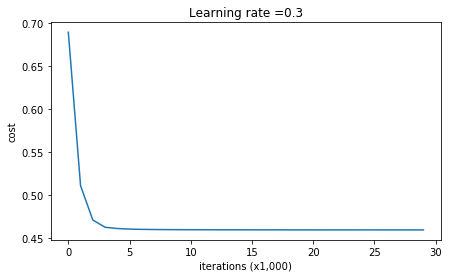

On the train set:
Accuracy: 0.905213270142
On the test set:
Accuracy: 0.915


In [22]:
"""
Let's now run the model with dropout (keep_prob = 0.86). It means at every iteration we shut down each neurons of layer 1 and 2 with 24% probability. The function model() will now call:

forward_propagation_with_dropout instead of forward_propagation.
backward_propagation_with_dropout instead of backward_propagation.
"""
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)


Cost after iteration 0: 0.689127184832917


C:\Users\I327950\Desktop\Deeplearning-AI\Improving Deep Neural Networks\reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\I327950\Desktop\Deeplearning-AI\Improving Deep Neural Networks\reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.46014459787763845
Cost after iteration 20000: 0.45995032986063905


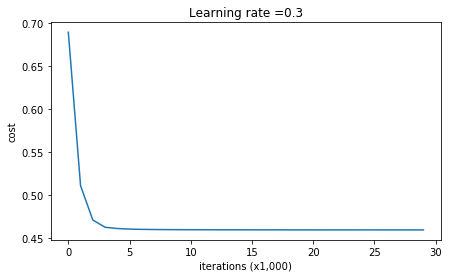

On the train set:
Accuracy: 0.905213270142
On the test set:
Accuracy: 0.915


In [23]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

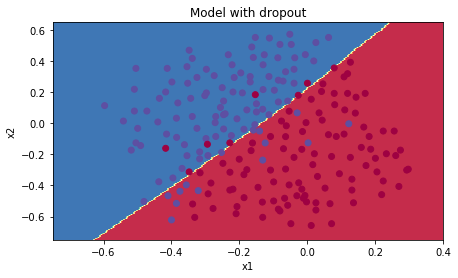

In [24]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
"""
Note:

A common mistake when using dropout is to use it both in training and testing. We should use dropout (randomly eliminate nodes) only in training.
Deep learning frameworks like tensorflow, PaddlePaddle, keras or caffe come with a dropout layer implementation. Don't stress - we will soon learn some of these frameworks.
What we should remember about dropout:

Dropout is a regularization technique.
We only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
Apply dropout both during forward and backward propagation.
During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. We can check that this works even when keep_prob is other values than 0.5.
"""